## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:01<00:00, 14369012.51it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268820.10it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4972508.34it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21854531.37it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [46]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [35]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes),
        )

    def forward(self, inp):
        return self.model(inp)

In [36]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


Your experiments come here:

In [50]:
import time
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    train_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        ep_train_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model.forward(X_batch)

            loss = loss_fn(y_pred, y_batch)
            loss.backward()

            opt.step()
            opt.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ep_train_loss.append(loss.item())
            accuracy = (torch.argmax(y_pred, 1) == y_batch).type(torch.float32)
            ep_train_accuracy.append(accuracy.mean().item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # compute predictions
                y_pred = model.forward(X_batch)
                loss = loss_fn(y_pred, y_batch)
                ### YOUR CODE HERE
                ep_val_loss.append(loss.item())### YOUR CODE HERE)
                #y_pred = ### YOUR CODE HERE
                ep_val_loss.append(loss.item())
                accuracy = (torch.argmax(y_pred, 1) == y_batch).type(torch.float32)
                ep_val_accuracy.append(accuracy.mean().item())
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        train_accuracy.append(np.mean(ep_train_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, train_accuracy, val_accuracy

In [60]:
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()


In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs = 10)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [55]:
from torch.utils.data import Subset
new_size = len(fmnist_dataset_train) // 10

# Create a subset of the original dataset with the new size
small_fmnist_dataset_train = Subset(fmnist_dataset_train, range(new_size))
train_small_loader = torch.utils.data.DataLoader(small_fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [62]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 700),
            nn.ReLU(),
            nn.Linear(700, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

In [45]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 700]         549,500
              ReLU-3                  [-1, 700]               0
            Linear-4                  [-1, 500]         350,500
              ReLU-5                  [-1, 500]               0
            Linear-6                  [-1, 200]         100,200
              ReLU-7                  [-1, 200]               0
            Linear-8                   [-1, 10]           2,010
Total params: 1,002,210
Trainable params: 1,002,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.82
Estimated Total Size (MB): 3.85
----------------------------------------------------------------


In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, train_small_loader, test_loader, loss_func, opt, n_epochs = 10)

# Your experiments, come here

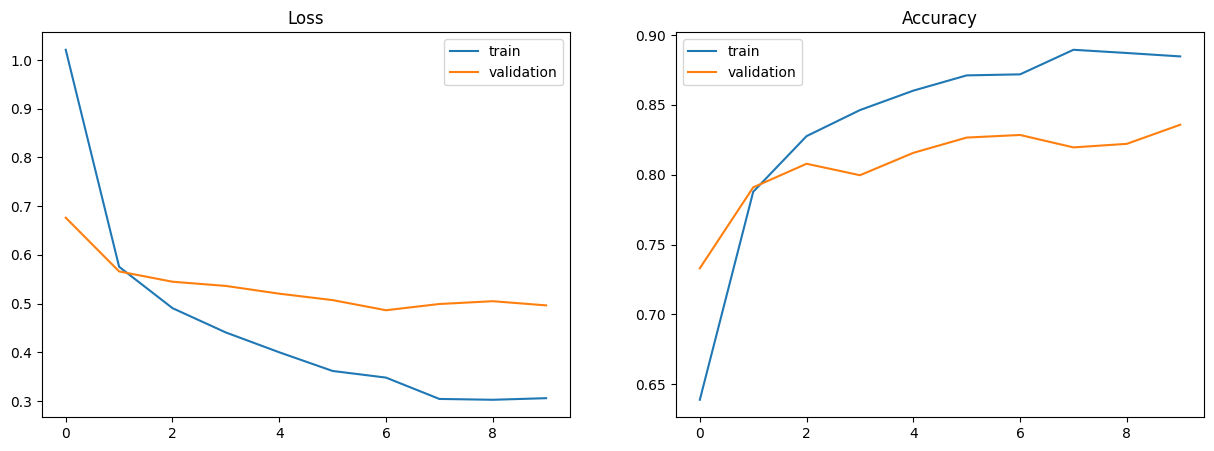

In [61]:
plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [70]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 700),
            nn.Dropout(p=0.7),
            nn.BatchNorm1d(700),
            nn.ReLU(),
            nn.Linear(700, 500),
            nn.Dropout(p=0.7),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.Dropout(p=0.7),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [71]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

train_loss, val_loss, train_accuracy, val_accuracy = train_model(model, train_small_loader, test_loader, loss_func, opt, n_epochs = 10)

Epoch 1 of 10 took 3.579s
	  training loss: 1.881701
	validation loss: 1.744581
	validation accuracy: 0.451
Epoch 2 of 10 took 3.606s
	  training loss: 1.206515
	validation loss: 1.180716
	validation accuracy: 0.703
Epoch 3 of 10 took 4.686s
	  training loss: 0.927746
	validation loss: 0.853876
	validation accuracy: 0.756
Epoch 4 of 10 took 3.616s
	  training loss: 0.801863
	validation loss: 0.748186
	validation accuracy: 0.778
Epoch 5 of 10 took 3.555s
	  training loss: 0.739799
	validation loss: 0.674656
	validation accuracy: 0.782
Epoch 6 of 10 took 4.520s
	  training loss: 0.694275
	validation loss: 0.635014
	validation accuracy: 0.788
Epoch 7 of 10 took 3.526s
	  training loss: 0.658136
	validation loss: 0.600671
	validation accuracy: 0.792
Epoch 8 of 10 took 3.440s
	  training loss: 0.632235
	validation loss: 0.587385
	validation accuracy: 0.791
Epoch 9 of 10 took 3.807s
	  training loss: 0.615518
	validation loss: 0.556327
	validation accuracy: 0.796
Epoch 10 of 10 took 4.514s
	

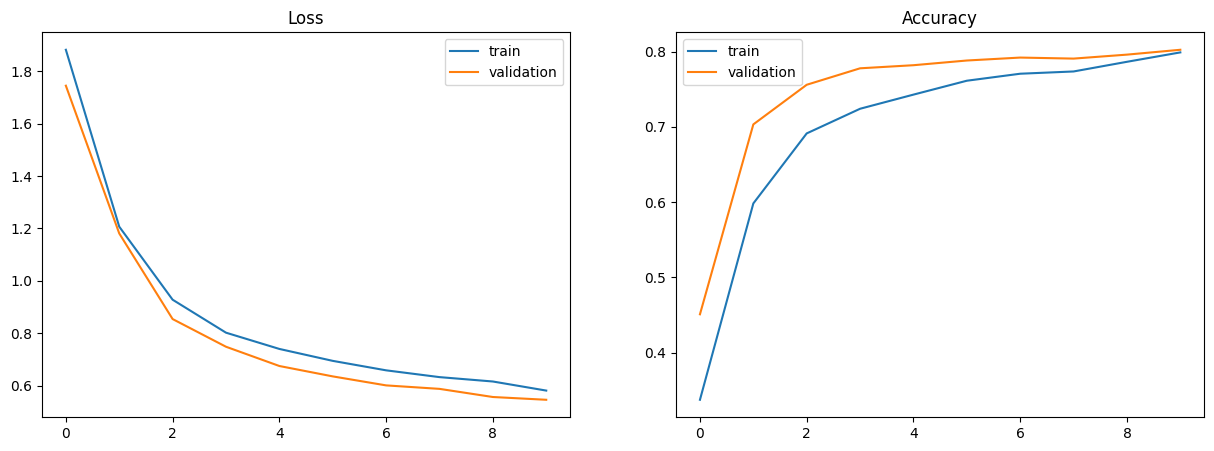

In [72]:
plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy)

### Conclusions:
_Write down small report with your conclusions and your ideas._

Regularizations do work. The small gap between the train loss and the val loss plots means we have a small generalization error, therefore the model manages to generalize well, even though we only trained it on the 8-th part of the data.